# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020 The University of Manchester

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

events_sim = uproot.open('https://www.dropbox.com/s/nfcuartcswie507/PhaseSpaceSimulation.root?dl=1')
events_down = uproot.open('https://www.dropbox.com/s/nm7istkjtah00u6/B2HHH_MagnetDown.root?dl=1')
events_up = uproot.open('https://www.dropbox.com/s/mhbhx33rhc26wan/B2HHH_MagnetUp.root?dl=1')

# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []

# A counter for bookkeeping
event_counter = 0

# This outer loop is a technical loop of uproot over chunks of events
for data in events_sim[b'PhaseSpaceTree'].iterate([b'H*_P[XYZ]',b'H*_Charge']):
    # As Python can handle calculations with arrays, we can calculate derived quantities here
    pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
    pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
    pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)

    # This loop will go over individual events
    for i in range(0,len(data[b'H1_PZ'])):
        event_counter += 1
        # Decide here which events to analyse
        if (data[b'H1_PZ'][i] > 0) and (data[b'H2_PZ'][i] > 0) and (data[b'H3_PZ'][i] > 0):
            # Fill arrays of events to be plotted and analysed further below
            # Adding values for all three hadrons to the same variable here
            pT.append(pT_H1[i])
            pT.append(pT_H2[i])
            pT.append(pT_H3[i])
            pX.append(data[b'H1_PX'][i])
            pX.append(data[b'H2_PX'][i])
            pX.append(data[b'H3_PX'][i])
            pY.append(data[b'H1_PY'][i])
            pY.append(data[b'H2_PY'][i])
            pY.append(data[b'H3_PY'][i])
            pZ.append(data[b'H1_PZ'][i])
            pZ.append(data[b'H2_PZ'][i])
            pZ.append(data[b'H3_PZ'][i])
    
print('Read {:d} events'.format(event_counter))

[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 50000 events


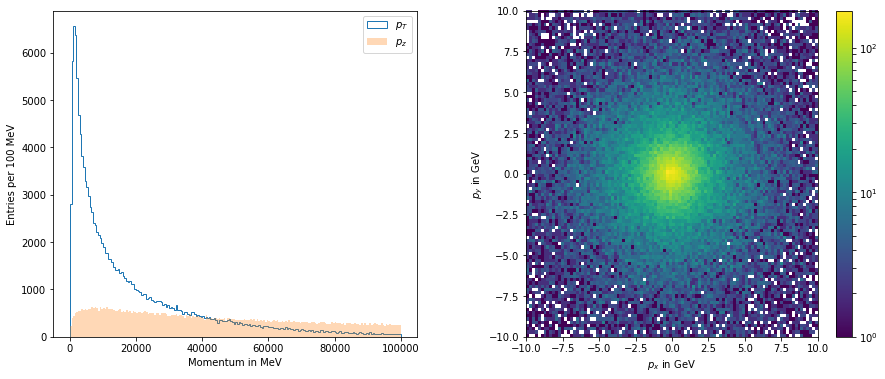

In [2]:
# Plot some histograms

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('$p_{x}$ in GeV')
ax[1].set_ylabel('$p_{y}$ in GeV')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale

Fit results
Par 1: 2891.358609 +/- 50.091583
Par 2: 0.000050 +/- 0.000001


Text(0,0.5,'Entries per 100 MeV')

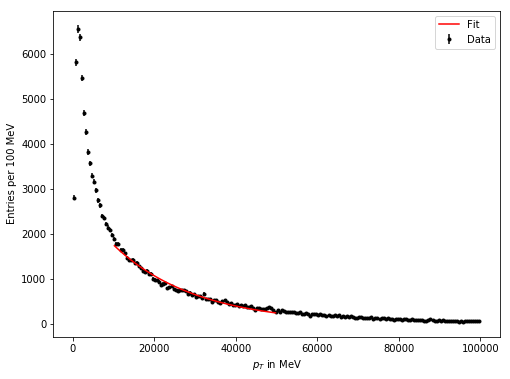

In [3]:
# decaying exponential function
def exponential(x, norm, decay):
    return np.array( norm * np.exp(-x*decay) )

# determine bin centres
bin_centres_pT = [(a+b)/2 for a,b in zip(bins_pT[0:-1],bins_pT[1:]) ] # uses simultaneous loop over two arrays

# reduce range to fit only part of curve
bin_centres_red_pT = [] 
values_red_pT = []
for c,v in zip(bin_centres_pT,values_pT):
    if c < 10000 or c > 50000: continue
    bin_centres_red_pT.append(c)
    values_red_pT.append(v)

# execute the fit with starting values 5000 and 10^-4
coeff_pT_exp,cov_pT_exp = curve_fit(exponential,bin_centres_red_pT,values_red_pT,p0=[5000,1e-4]) # fit
perr_pT_exp = np.sqrt(np.diag(cov_pT_exp)) # extract errors from covarianve matrix

# output fit results
print('Fit results')
parcount = 0
for p,e in zip(coeff_pT_exp,perr_pT_exp):
    parcount += 1
    print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# plot the data, this time as dots with error bars (sqrt(N) errors)
ax.errorbar(bin_centres_pT,values_pT,yerr=np.sqrt(values_pT),linestyle='',marker='.',
            markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

# plot the fit: create x values, then calculate the corresponding y values and plot
x_fit = np.linspace(bin_centres_red_pT[0],bin_centres_red_pT[-1],100)
y_fit = exponential(x_fit,coeff_pT_exp[0],coeff_pT_exp[1])
ax.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

# plot decoration
ax.legend()
ax.set_xlabel('$p_{T}$ in MeV')
ax.set_ylabel('Entries per 100 MeV')